In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import math 
import statsmodels.api as sm

On introduit un nouveau modèle de prédiction:
$C_i = C_{i-336} + \frac{1}{336}\sum_{k=0}^{336} C_{k+i-1-336} - C_{k+i-1-672}$ 

$C_i$ est ici la consommation à l'instant i qu'on souhaite prédire.
NB: $i$ correspond à un pas de temps de 30 minutes, donc 336 représente une semaine et 48 une journée.

Il s'agit d'un modèle où pour estimer la consommation à un instant i, on prend la consommation une semaine plus tôt au même instant et on la pénalise avec un coéfficient qui est en fait une moyenne mobile. Cette moyenne mobile est la moyenne des écarts observés dans la consommation entre la semaine qui a précédé cet instant et la semaine encore d'avant.

In [185]:
#Here is the function that predict the consumption
def prediction_semaine(region,timestep):
    data = pd.read_csv('data centrale/train/{}.csv'.format(region),index_col=0)
    train=np.array(data["Consommation"])
    semaine=7*24*2
    for i in range(timestep):
        ecart=-train[30672-2*semaine+i-1:30672-semaine+i-1]+train[30672-semaine+i-1:30672+i-1]
        moyenne_ec=(1/semaine)*sum(ecart)
        prediction=train[30672-semaine+i]+moyenne_ec
        train=np.append(train,prediction)
    pred=train[30673:]
    return pred


In [190]:
#We compare the prediction with the reality
def truevspred(region,timestep):
    pred=prediction_semaine(region,timestep)
    test = pd.read_csv('data centrale/test/{}.csv'.format(region),index_col=0)
    true=np.array(test["Consumption"])
    b=true[:timestep-1]
    plt.plot(pred,label="prediction")
    plt.plot(b,label="True")
    plt.title("Prediction vs True")
    plt.xlabel("timestep")
    plt.ylabel("Consumption (MW)")
    plt.legend()

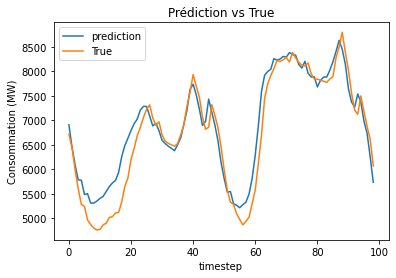

In [192]:
truevspred("ile de france",100)

In [130]:
#We take a look at the error
def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [204]:
#we take a critical look at our model by looking at its relevance according to the time step
def evol_erreur(region,timestep):
    erreur=[]
    test = pd.read_csv('data centrale/test/{}.csv'.format(region),index_col=0)
    truedata=np.array(test["Consommation"])
    for i in range(1,timestep+2):
        pred=prediction_semaine(region,i)
        true=truedata[:i-1]
        erreur.append(mean_absolute_percentage_error(true,pred))
        
    plt.plot(erreur,label="erreur en %")
    plt.title("Evolution of the error as a function of the length of the prediction")
    plt.xlabel("timestep")
    plt.ylabel("Error")
    plt.legend()
        
        
    

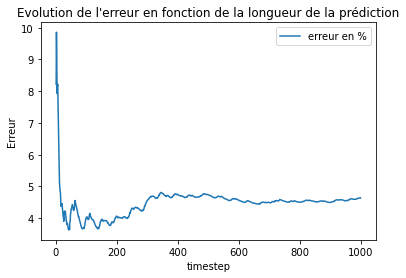

In [208]:
evol_erreur("bretagne",1000)